In [1]:
import os
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
importances = {}
scores = {}
feature_names = {}

for stage in STAGES:
    with open(os.path.join(RESULTS_PATH, f'randomForest_avg{CAF_DOSE}', f'importances-{stage}.pickle'), 'rb') as file:
        importances[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, f'randomForest_avg{CAF_DOSE}', f'scores-{stage}.pickle'), 'rb') as file:
        scores[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, f'randomForest_avg{CAF_DOSE}', f'feature_names-{stage}.pickle'), 'rb') as file:
        feature_names[stage] = pickle.load(file)

In [5]:
importance_means = {}
importance_stds = {}
for stage in STAGES:
    importance_means[stage] = np.mean(importances[stage], axis=0)
    importance_stds[stage] = np.std(importances[stage], axis=0)

score_means = {}
score_stds = {}
for stage in STAGES:
    score_means[stage] = np.mean(scores[stage])
    score_stds[stage] = np.std(scores[stage])

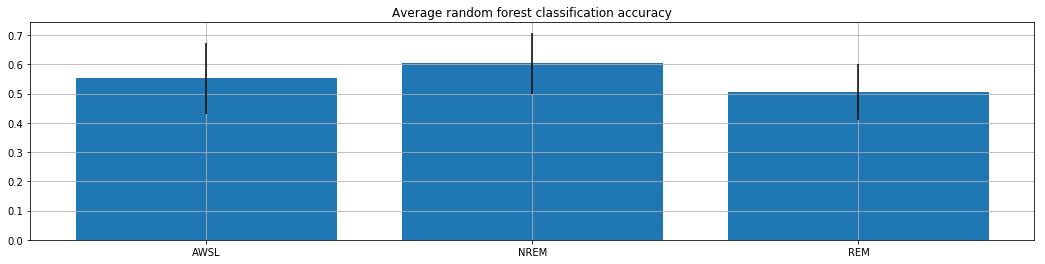

In [6]:
plt.figure(figsize=(18, 4))
plt.title('Average random forest classification accuracy')
plt.bar(np.arange(len(score_means)), score_means.values(), yerr=score_stds.values())
plt.xticks(np.arange(len(score_means)), STAGES)
plt.grid()
plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', 'accuracy'))
plt.show()

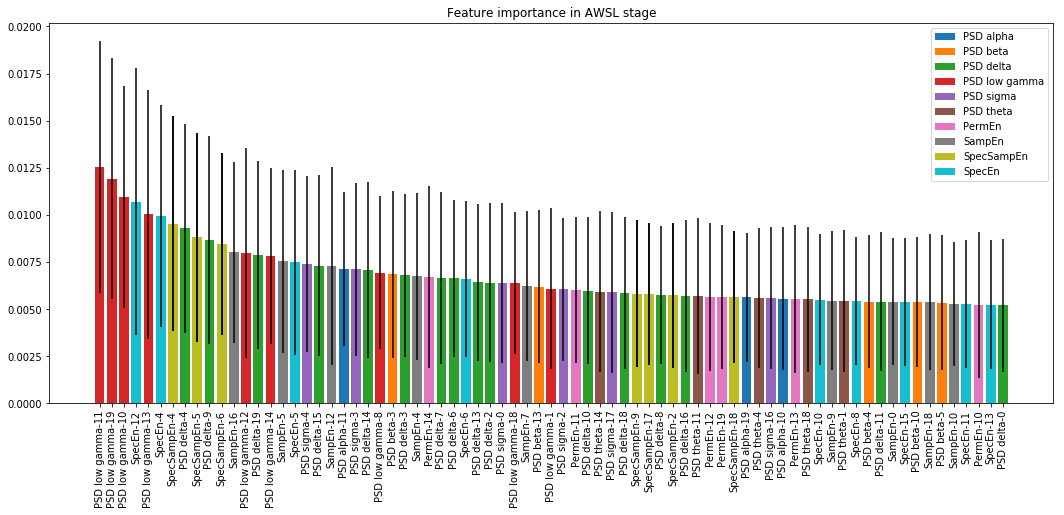

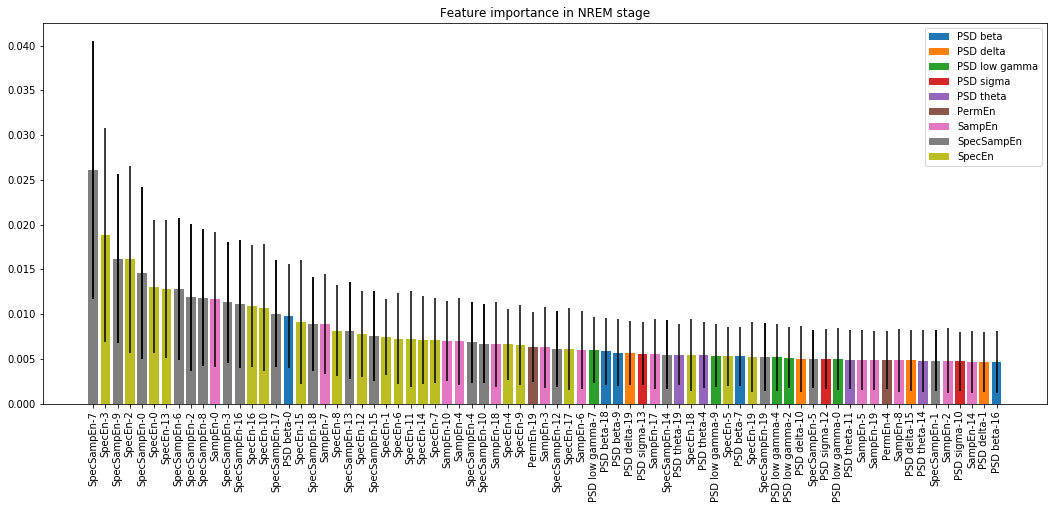

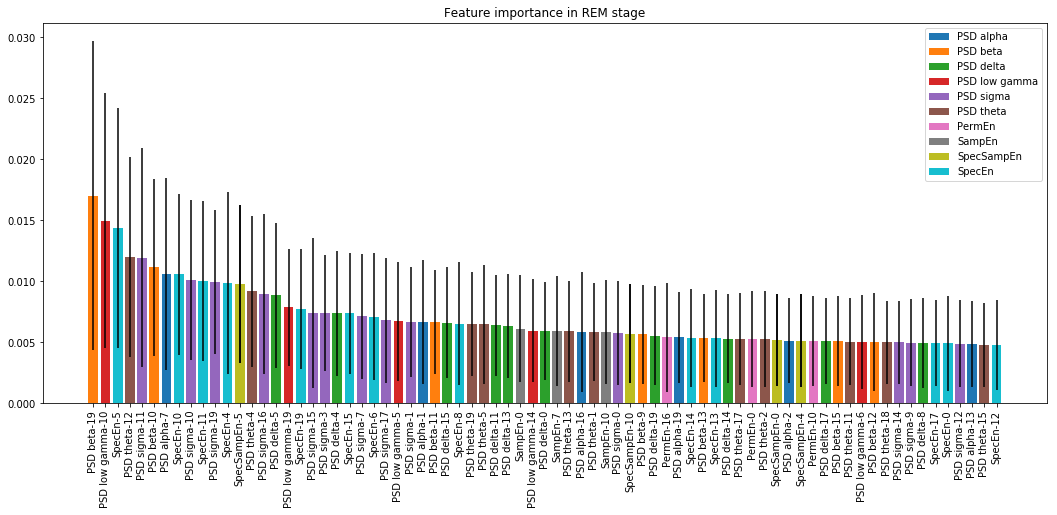

In [7]:
for stage in STAGES:
    indices = np.argsort(importance_means[stage])[::-1][:75]
    
    plt.figure(figsize=(18, 7))
    plt.title(f'Feature importance in {stage} stage')
    
    feature_categories = np.unique([name.split('-')[0] for name in feature_names[stage]])
    for category in feature_categories:
        mask = [category in name for name in feature_names[stage][indices]]
        if np.sum(mask) > 0:
            plt.bar(np.arange(len(indices))[mask], importance_means[stage][indices][mask], yerr=importance_stds[stage][indices][mask], label=category.replace('Shan', '').replace('_', ' '))
    
    plt.xticks(np.arange(len(indices)), [name.replace('_', ' ').replace('Shan', '') for name in feature_names[stage][indices]], rotation=90)
    plt.legend()
    plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', f'importance_bars_{stage}'))
    plt.show()

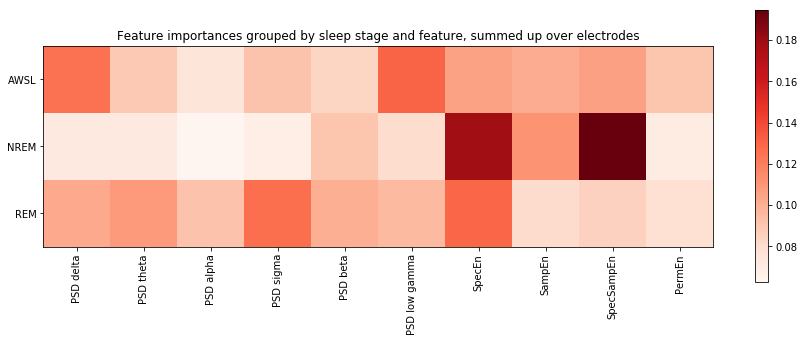

In [8]:
# get feature categories, remove duplicate elements from list while preserving order
seen = set()
seen_add = seen.add
feature_categories = [name.split('-')[0] for name in feature_names[STAGES[0]] if not (name.split('-')[0] in seen or seen_add(name.split('-')[0]))]

matrix = np.empty((len(STAGES), len(feature_categories)))

for i, stage in enumerate(STAGES):
    for j, category in enumerate(feature_categories):
        mask = [category == name.split('-')[0] for name in feature_names[stage]]
        matrix[i,j] = np.sum(importance_means[stage][mask])

plt.figure(figsize=(15, 5))
plt.title('Feature importances grouped by sleep stage and feature, summed up over electrodes')
plt.imshow(matrix, cmap='Reds')
plt.xticks(np.arange(len(feature_categories)), [cat.replace('_', ' ').replace('Shan', '') for cat in feature_categories], rotation=90)
plt.yticks(np.arange(len(STAGES)), STAGES)
plt.colorbar()
plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', 'feature_category_heatmap'))
plt.show()

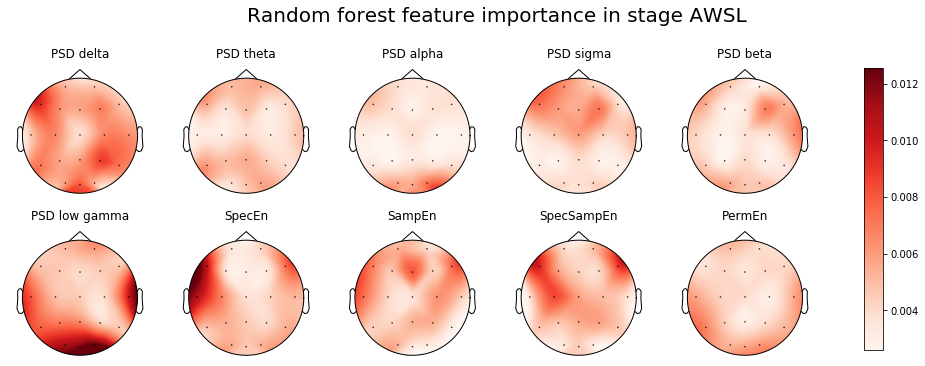

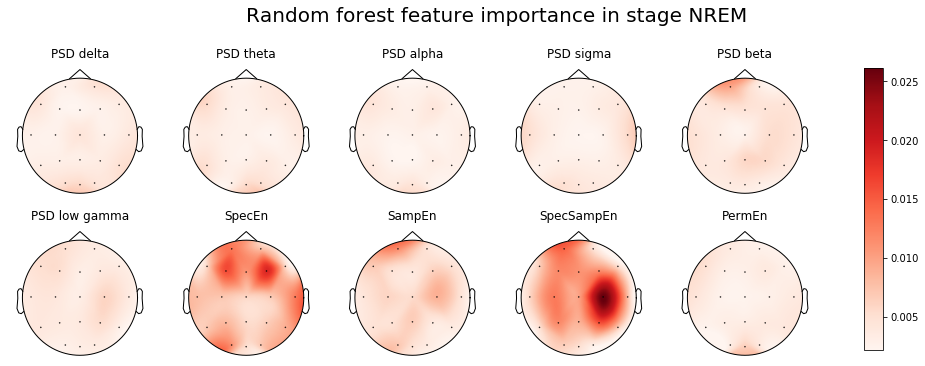

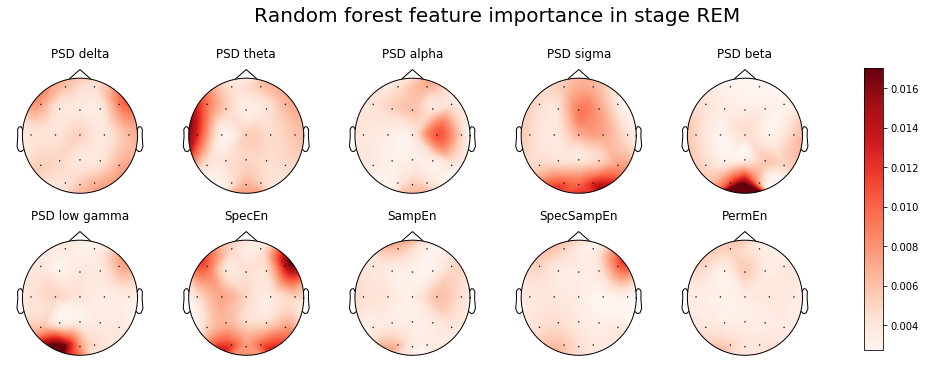

In [9]:
colormap = 'Reds'

for stage in STAGES:
    # reshape the importance vector into a feature by electrode matrix
    mean = importance_means[stage].reshape((-1, 20))

    vmin, vmax = np.min(mean), np.max(mean)
    
    # get the cleaned names features
    features = [name.split('-')[0] for name in feature_names[stage][::20]]
    
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Random forest feature importance in stage {stage}', fontsize=20, y=1.1)
    
    axes = []
    for i in range(mean.shape[0]):
        # plot the current feature importance map in a new subplot
        axes.append(plt.subplot(2, 5, i + 1))
        plt.title(features[i].replace('Shan', '').replace('_', ' '))
        viz.plot_topomap(mean[i], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    # add a colorbar to the figure
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', f'importance_topomaps_{stage}'))
    plt.show()